# Used Car Auction Sales

Elimelech Berlin  
January 2024

## Context

## Data

## EDA

Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, time, datetime
import mplcursors as mpc

# set visualization theme
sns.set_theme()

Load the data:
(While running `pd.read_csv('data/car_prices.csv')`, this error was raised: 'ParserError: Error tokenizing data. C error: Expected 16 fields in line 408163, saw 17'). To fix the issue causing this, I examined the file in Notepad & found an error (extra comma in original csv file. So I edited it manually.)

In [2]:
# load csv file into a dataframe, raise a warning when rows cannot be loaded
df = pd.read_csv('data/car_prices.csv', on_bad_lines='warn')

Skipping line 408163: expected 16 fields, saw 17
Skipping line 417837: expected 16 fields, saw 17
Skipping line 421291: expected 16 fields, saw 17
Skipping line 424163: expected 16 fields, saw 17

Skipping line 427042: expected 16 fields, saw 17
Skipping line 427045: expected 16 fields, saw 17
Skipping line 434426: expected 16 fields, saw 17
Skipping line 444503: expected 16 fields, saw 17
Skipping line 453796: expected 16 fields, saw 17

Skipping line 461599: expected 16 fields, saw 17
Skipping line 461614: expected 16 fields, saw 17

Skipping line 492486: expected 16 fields, saw 17
Skipping line 497010: expected 16 fields, saw 17
Skipping line 497013: expected 16 fields, saw 17
Skipping line 499085: expected 16 fields, saw 17
Skipping line 501457: expected 16 fields, saw 17
Skipping line 505301: expected 16 fields, saw 17
Skipping line 505308: expected 16 fields, saw 17
Skipping line 520463: expected 16 fields, saw 17

Skipping line 528998: expected 16 fields, saw 17
Skipping line 52

> ~ 25 rows are dropped from the data

Let's have a look at the shape of the data:

In [3]:
df.shape

(558811, 16)

> There are 550k+ records describeed by 16 columns/features.

To gain further understanding of the data, view colunm names & the first few rows of the data:

In [4]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [5]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


> What most of the columns describe is self explanatory. Nearly all of the columns describe features that are relevant to our analysis, even the VIN is relevant, as some of the information encoded in it may affect vehicle price. (That information will be extracted & a new column created for it.) 'Seller' may be dropped as that will be diffucult, if not impossible to extract meaningful insight from it. Saledate may prove useful, as seasonality (month), day of week & time of day may play a role in the saleprice, however, that column must divided into several different features.

Now, let's drop 'Seller' column:

In [6]:
df.drop(['seller'], axis=1, inplace=True)

With the irrelevant column removed, we can proceed with cleaning & prepping the data. First, check for missing values:

In [7]:
df.isna().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 0
state               0
condition       11794
odometer           94
color             749
interior          749
mmr                 0
sellingprice        0
saledate            1
dtype: int64

> There are several columns missing 10k+ values: make, model, trim, body, transmission, condition. Let's investigate this further by investigating if the above missing values are present in the same rows:

In [8]:
df[df['make'].isna()].isna().sum()

year                0
make            10301
model           10301
trim            10301
body            10301
transmission     1761
vin                 0
state               0
condition          87
odometer            4
color              15
interior           15
mmr                 0
sellingprice        0
saledate            0
dtype: int64

> We see many rows are missing information in several colmns. The missing information is likely essential to our undersstanding of what drives value for the vehicles & we can't learn enough info without it. Although some of the missing information can be derived from VINs of those cars, we will drop those records from the dataframe & exclude them from this analysis.

In [9]:
# create new dataframe without null values
df2 = df.dropna().reset_index(drop=True)

Let's now have a look at the datatypes present in the dataset:

In [10]:
df2.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer         object
color            object
interior         object
mmr               int64
sellingprice     object
saledate         object
dtype: object

> Several columns are present in the wrong data type: odometer, selling price & saledate. Of those 3, saledate is the only one that will not be transformed to numeric dtype, it will be changed to datetime.  

To deal with these columns, lets's begin with column 'odometer'. Examine individual values to learn if the entire column is non-numeric (which can be addresed by a simple transformation of dtype) or if there are problems with specific values:

In [11]:
type(df2.iloc[22265]['odometer'])

float

> The above output shows that there are numeric-types present in the column, which indicates that non-numeric dtypes are likely a result of incorrectly saved values. To deal with this, first attempt to simply change the datatype:

In [12]:
df2['odometer'] = pd.to_numeric(df2['odometer'])

In [13]:
df2.odometer.dtypes

dtype('float64')

> That seems to have solved the problem, as everything was converted without any errors.

Now, let's attempt the same solution for sellingprice:

In [14]:
df2['sellingprice'] = pd.to_numeric(df2['sellingprice'])

In [15]:
df2.sellingprice.dtypes

dtype('int64')

> With the numeric type columns succesfully converted, let's transform the 'saledate' column to datetime-like type.

First, view dtypes present in the column, & then view an example:

In [16]:
# view datatypes present in the column
df2.saledate.dtypes

dtype('O')

> That worked without a problem.

Proceed to replace the original column with a transformed version. To correctly format the format string used as an argument to the datetime.strptime method, preview the saletime value for one of the rows:

In [17]:
print(df2['saledate'][26846])
type(df2['saledate'][26846])

Thu Jan 22 2015 06:30:00 GMT-0800 (PST)


str

> The above output shows that the data in saledate is a string. Let's proceed to transform it to a datetime object:

In [18]:
df2['saledate'] = [datetime.strptime(d.replace(' (PST)', '').replace(' (PDT)', ''), "%a %b %d %Y %H:%M:%S GMT%z") for d in df2['saledate']]

Now, iterate through every saledate to ensure correct transformation:

In [19]:
for i in df2.index:
    if not isinstance(df2['saledate'][i], datetime):
        print(type(df2['saledate'][i]))

Let's now convert all strings to be lowercase to ensure that no errors arrise from different forms of the same words/letters:

In [20]:
conv_cols = []

for col in df2.columns:
    try:
        df2[col] = df2[col].str.lower()
        conv_cols.append(col)
    except:
        pass
    
print('The following columns are present in lowercase letters:{}'.format(conv_cols))

The following columns are present in lowercase letters:['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior']


Let's check for duplicated rows. Although there may be some redundancy in column 'vin', this may result from multiple sales for a single vehicle.

In [21]:
df2.duplicated(subset='vin').sum()

6557

> There are a number of vehicles listed more than once. This may not be an issue with redundant information, as a single vehicle may have been sold multiple times. To investigate this, let's view some of the duplicates & than check if all columns are duplicated:

In [22]:
df2[df2.duplicated(subset='vin', keep=False)].sort_values(by = 'vin')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,mmr,sellingprice,saledate
178324,2000,acura,tl,3.2,sedan,automatic,19uua5663ya022038,fl,1.9,105431.0,gold,tan,2325,1000,2015-01-27 10:00:00-08:00
31978,2000,acura,tl,3.2,sedan,automatic,19uua5663ya022038,fl,1.9,105420.0,gold,beige,2150,1100,2014-12-23 12:15:00-08:00
128236,2006,acura,tl,base,sedan,manual,19uua65596a059705,nj,2.6,89661.0,white,brown,9025,8200,2015-01-28 01:30:00-08:00
289231,2006,acura,tl,base,sedan,manual,19uua65596a059705,nj,2.5,89741.0,white,black,9100,8500,2015-03-04 01:30:00-08:00
150649,2005,acura,tl,3.2,sedan,automatic,19uua66215a070166,ca,3.7,131727.0,silver,gray,6600,6900,2015-01-22 04:00:00-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209261,2006,maserati,quattroporte,base,sedan,automatic,zamce39a460025306,ca,2.9,92655.0,silver,black,17250,15500,2015-02-04 04:30:00-08:00
166118,2007,maserati,quattroporte,executive gt duoselect,sedan,automatic,zamce39a470026893,ca,2.7,46087.0,gray,gray,25100,23000,2015-02-10 04:30:00-08:00
412054,2007,maserati,quattroporte,executive gt duoselect,sedan,automatic,zamce39a470026893,ca,3.4,46128.0,gray,gray,26800,23500,2015-06-04 05:30:00-07:00
101745,2014,fiat,500l,easy,wagon,automatic,zfbcfabh4ez025834,fl,4.0,9435.0,red,gray,12600,10200,2015-02-02 04:30:00-08:00


> In the above output we see several examples of rows with identical 'vin's but they are for records of different sales.

Let's now check the dataframe for rows that are truly duplicated (i.e multiple records for the same sale.). This can be done by looking for rows with identical values for 'vin' & 'saledate':

In [23]:
df2.duplicated(subset = ['vin', 'saledate']).sum()

56

> The above output shows that there are a small number of rows with identical 'vin' & 'saledate'. Let's view a dataframe with those records:

In [24]:
df2[df2.duplicated(subset = ['vin', 'saledate'], keep= False)].sort_values('vin')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,mmr,sellingprice,saledate
199574,2012,honda,civic,ex-l,sedan,automatic,19xfb2f97ce313922,md,4.4,68059.0,white,beige,11100,11600,2015-02-03 01:30:00-08:00
26380,2012,honda,civic,ex-l,sedan,automatic,19xfb2f97ce313922,md,4.0,1.0,white,beige,14150,3900,2015-02-03 01:30:00-08:00
12625,2007,dodge,caliber,sxt,wagon,automatic,1b3hb48bx7d113596,ga,2.0,1.0,red,gray,5100,2300,2015-01-22 04:30:00-08:00
150018,2007,dodge,caliber,sxt,wagon,automatic,1b3hb48bx7d113596,ga,2.0,326716.0,red,gray,1175,900,2015-01-22 04:30:00-08:00
151411,2001,dodge,dakota,base,club cab,automatic,1b7gg22n01s348630,az,1.0,140318.0,black,black,1600,2200,2015-01-22 03:00:00-08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472314,2008,bmw,1 series,135i,convertible,automatic,wbaun93588vf56134,ca,3.3,96344.0,red,black,12500,13000,2015-07-08 09:30:00-07:00
102673,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j23a235692,nc,1.3,146913.0,black,tan,4375,2800,2015-01-13 09:15:00-08:00
16429,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j23a235692,nc,1.2,1.0,black,tan,7225,2000,2015-01-13 09:15:00-08:00
280622,2007,mercedes-benz,cls-class,cls550,sedan,automatic,wdddj72x27a080493,mo,2.1,79869.0,gray,black,15400,17000,2015-07-08 07:30:00-07:00


> Several unexpected values are present in the above dataframe: some rows describe an identical sale, but with different values for some of the columns. Some of them are obviously errors, as one of the rows have '1.0' as the record for the odometer but another row for the same vehicle/sale has a number better aligned with what one would expect for a vehicle several years old.

Let's proceed by dropping rows with '1.0' as odometer value:

In [25]:
for r in df2[df2.duplicated(subset = ['vin', 'saledate'], keep= False)].index:
    if df2.loc[r]['odometer'] == 1.0:
        df2.drop(r, inplace=True)

> View the remaining duplicate rows & examine for any apparent errors:

In [26]:
df2[df2.duplicated(subset = ['vin', 'saledate'], keep= False)].sort_values('vin').shape

(42, 15)

In [27]:
df2[df2.duplicated(subset = ['vin', 'saledate'], keep= False)].sort_values('vin')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,mmr,sellingprice,saledate
408840,2011,dodge,durango,crew,suv,automatic,1d4se4gt5bc746627,tx,2.1,54456.0,gray,gray,20800,17500,2015-07-08 07:20:00-07:00
461611,2011,dodge,durango,crew,suv,automatic,1d4se4gt5bc746627,tx,2.1,54456.0,gray,gray,20800,19000,2015-07-08 07:20:00-07:00
135484,2010,ford,f-150,platinum,supercrew,automatic,1ftfw1cv5afb30053,fl,4.0,129753.0,white,brown,16200,15800,2015-01-21 01:00:00-08:00
99104,2010,ford,f-150,platinum,supercrew,automatic,1ftfw1cv5afb30053,fl,3.7,129750.0,white,brown,16200,17900,2015-01-21 01:00:00-08:00
28926,2008,ford,f-150,fx4,supercrew,automatic,1ftpw14588fa92105,ca,2.6,56720.0,gray,gray,17900,21600,2014-12-31 12:15:00-08:00
39281,2008,ford,f-150,fx4,supercrew,automatic,1ftpw14588fa92105,ca,4.4,56724.0,gray,gray,17800,19500,2014-12-31 12:15:00-08:00
137950,2004,chevrolet,corvette,z06,coupe,manual,1g1yy12s045121256,nj,4.1,69537.0,yellow,black,18450,17000,2015-07-08 09:30:00-07:00
366912,2004,chevrolet,corvette,z06,coupe,manual,1g1yy12s045121256,ca,4.1,69537.0,yellow,black,18450,20000,2015-07-08 09:30:00-07:00
466361,2003,cadillac,seville,sts,sedan,automatic,1g6ky54973u197868,oh,2.1,135318.0,white,beige,1525,1050,2015-06-18 02:00:00-07:00
471252,2003,cadillac,seville,sts,sedan,automatic,1g6ky54973u197868,oh,2.1,135321.0,white,beige,1325,700,2015-06-18 02:00:00-07:00


> In the above output, there are duplicate rows representing a single sale (identical saledate info), with differing sellingprice values. With no way to verify which of those records is accurate, proceed to drop all of the duplicated rows. (It's a loss of only 21 rows, a negligible percentage of the entire dataframe):

In [28]:
df2.drop(df2[df2.duplicated(subset = ['vin', 'saledate'], keep = False)].index, inplace=True)

In [29]:
df2['state'].value_counts()

state
fl    75238
ca    66203
tx    41650
ga    30935
pa    24115
nj    23000
il    21501
oh    20285
tn    19181
nc    18725
mo    15281
mi    14184
nv    11671
md     9787
va     9449
wi     9196
mn     8627
az     7610
wa     7012
co     6270
ma     6165
ny     4749
in     3878
sc     3752
ne     3685
pr     2426
la     1744
ms     1730
ut     1716
hi     1205
or     1047
nm      163
ok       54
al       25
Name: count, dtype: int64

### Feature Engineering
With the dataset cleaned of missing & duplicate records, we proceed to create several new columns to help us understand the data: 'savings' & 'region'.
#### Savings
As the value of a given vehicle is often determined by its MMR, a sale below that price can be considered a good buy. To aid in identifying patterns common to such deals, we will create a new coulmn, 'savings', calculated by subtracting 'sellinprice' for each record, from its 'mmr'.

In [30]:
# create new column: 'savings'
df2['savings'] = df2['mmr'] - df2['sellingprice']

> The above operation produces a column 'savings' that expresses the difference between 'mmr' & 'sellingprice' as a dollar amount. It may be more informative to work with savings as a percentage in relation to 'mmr' as oppossed to a dollar amount. Let's create a column, 'savings%' to show the relationship between 'mmr' & 'sellingprice' as a percentage:

In [31]:
# calculate difference betweeen 'mmr' & 'sellingprice' & format it as a percentage of change from 'mmr'
df2['savings%'] = (df2['mmr'] - df2['sellingprice'])/df2['mmr'] *100

In [32]:
df2.iloc[59782]

year                                 2007
make                            chevrolet
model              silverado 1500 classic
trim                                   ls
body                         extended cab
transmission                    automatic
vin                     1gcec19xx7z596632
state                                  ca
condition                             1.9
odometer                         112798.0
color                                 red
interior                           silver
mmr                                  7075
sellingprice                         9300
saledate        2015-01-07 12:30:00-08:00
savings                             -2225
savings%                       -31.448763
Name: 59796, dtype: object

#### Region of Origin
A factor that may influence a vehicles resale price is the place where the manufacturer is located/based. Although this information is not present in the original dataset,  it may be derived from the 'vin' given for each vehicle. [The vin, or vehicle identification numer, is an alphanumeric code that uniquely identifies every vehicle & provides a variety of information about a it.] According to an article on [Edmunds](https://www.edmunds.com/how-to/how-to-quickly-decode-your-vin.html), the first three digits of that code are collectively referred to as the World Manufacturer Identifier (WMI). The first digit tells us the location of the manfacturer as follows:

| Character | Region |
|---|---|
A-C | Africa
J-R | Asia
S-Z | Europe
1-5 | North America
6-7 | Oceania 
8-9 | South America

Let's proceed to create a column, 'region', by mapping each row to one of the above regions based on the first digit of the 'vin':

In [33]:
# create a dictionary mapping the first vin digit to region names

region_dict = {}

for l in 'abcdefghijklmnopqrstuvwxyz123456789':
    
    if l in 'abc':
        region_dict[l] = 'africa'
        
    if l in 'jklmnopqr':
        region_dict[l] = 'asia'
        
    if l in 'stuvwxyz':
        region_dict[l] = 'europe'
        
    if l in '12345':
        region_dict[l] = 'north_america'
        
    if l in '67':
        region_dict[l] = 'oceania'
        
    if l in '89':
        region_dict[l] = 'south_america'  

In [34]:
df2['region'] = [region_dict[x] for x in df2['vin'].apply(lambda x: x[:1])]

In [35]:
# preview the dataframe with the new columns
df2.head(30) 

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,mmr,sellingprice,saledate,savings,savings%,region
0,2015,kia,sorento,lx,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,20500,21500,2014-12-16 12:30:00-08:00,-1000,-4.878049,north_america
1,2015,kia,sorento,lx,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,20800,21500,2014-12-16 12:30:00-08:00,-700,-3.365385,north_america
2,2014,bmw,3 series,328i sulev,sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,31900,30000,2015-01-15 04:30:00-08:00,1900,5.956113,europe
3,2015,volvo,s60,t5,sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,27500,27750,2015-01-29 04:30:00-08:00,-250,-0.909091,europe
4,2014,bmw,6 series gran coupe,650i,sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,66000,67000,2014-12-18 12:30:00-08:00,-1000,-1.515152,europe
5,2015,nissan,altima,2.5 s,sedan,automatic,1n4al3ap1fn326013,ca,1.0,5554.0,gray,black,15350,10900,2014-12-30 12:00:00-08:00,4450,28.990228,north_america
6,2014,bmw,m5,base,sedan,automatic,wbsfv9c51ed593089,ca,3.4,14943.0,black,black,69000,65000,2014-12-17 12:30:00-08:00,4000,5.797101,europe
7,2014,chevrolet,cruze,1lt,sedan,automatic,1g1pc5sb2e7128460,ca,2.0,28617.0,black,black,11900,9800,2014-12-16 13:00:00-08:00,2100,17.647059,north_america
8,2014,audi,a4,2.0t premium plus quattro,sedan,automatic,wauffafl3en030343,ca,4.2,9557.0,white,black,32100,32250,2014-12-18 12:00:00-08:00,-150,-0.467290,europe
9,2014,chevrolet,camaro,lt,convertible,automatic,2g1fb3d37e9218789,ca,3.0,4809.0,red,black,26300,17500,2015-01-20 04:00:00-08:00,8800,33.460076,north_america


We are finished with deriving relevant information from the 'vin' column, let's drop it from the dataset:

In [36]:
df2.drop(['vin'], axis=1, inplace=True)

With the data now cleaned of missing values & duplicate rows, & several important features introduced to the dataset the data prerocessing stage is complete. We now proceed with exploring the data.  
We begin by comparing the two potential target features: 'savings' & 'savings%'. Let's explore the number of sales considered outliers by each metric:

In [37]:
sav_q1 = df2['savings'].quantile(.25)
sav_q3 = df2['savings'].quantile(.75)

sav_perc_q1 = df2['savings%'].quantile(.25)
sav_perc_q3 = df2['savings%'].quantile(.75)

In [38]:
sav_non_outliers = df2[(df2['savings'] > sav_perc_q1) & (df2['savings'] < sav_q3)].shape[0]

In [39]:
sav_perc_non_outliers = df2[(df2['savings%'] > sav_q1) & (df2['savings%'] < sav_perc_q3)].shape[0]

In [40]:
sav_non_outliers / df2.shape[0] * 100

27.6655394603385

In [41]:
sav_perc_non_outliers / df2.shape[0] * 100

74.97474902542885

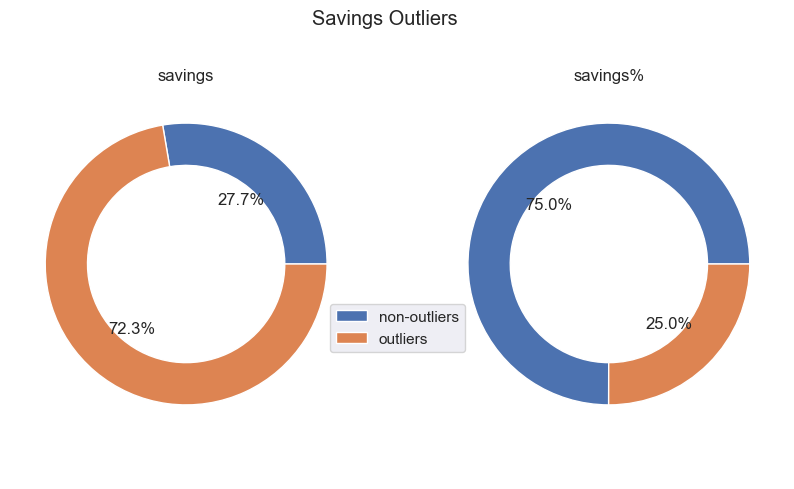

In [42]:
# create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# add title
fig.suptitle('Savings Outliers', y= .75)

# plot axes 0
axes[0].pie([sav_non_outliers, df2.shape[0] - sav_non_outliers], wedgeprops=({'width':.3}), autopct='%1.1f%%', labeldistance=.25)
axes[0].set_title('savings')

# plot axes 1
wedges, _, pct = axes[1].pie([sav_perc_non_outliers, df2.shape[0] - sav_perc_non_outliers], wedgeprops=({'width':.3}), autopct='%1.1f%%')
axes[1].set_title('savings%')

# add legend to figure
fig.legend(['non-outliers', 'outliers'], loc=(.415, .28));

In [43]:
pct

[Text(-0.4239274065224415, 0.4246004639648391, '75.0%'),
 Text(0.42392744627640405, -0.424600424273889, '25.0%')]

> The above plots show that when taken as a percentage of 'mmr', far more observations are not considered outliers. For this reason, this report will focus on that feature as the primary target feature, but certain business use cases may indicate a need to focus on savings as a value & for this reason we will keep that column in the dataset.

Let's proceed by dropping the outlier rows (by savings%):

In [44]:
df3 = df2[(df2['savings%'] > sav_q1) & (df2['savings%'] < sav_perc_q3)]

Let's now proceed by getting a perspective on the relationship amongst the features present in the dataset by viewing heatmap of the correlation between features:

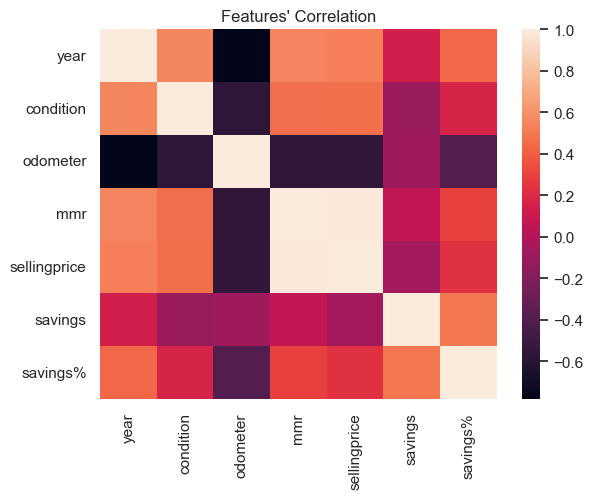

In [60]:
sns.heatmap(df3.corr(numeric_only=True))
plt.title("Features' Correlation");

In [61]:
df3.corr(numeric_only=True)

,year,condition,odometer,mmr,sellingprice,savings,savings%
year,1.000000,0.551549,-0.781287,0.542168,0.525639,0.137492,0.434688
condition,0.551549,1.000000,-0.568427,0.451437,0.463367,-0.096223,0.168522
odometer,-0.781287,-0.568427,1.000000,-0.554288,-0.544831,-0.079536,-0.395710
mmr,0.542168,0.451437,-0.554288,1.000000,0.992569,0.064516,0.290870
sellingprice,0.525639,0.463367,-0.544831,0.992569,1.000000,-0.057393,0.230847
savings,0.137492,-0.096223,-0.079536,0.064516,-0.057393,1.000000,0.493283
savings%,0.434688,0.168522,-0.395710,0.290870,0.230847,0.493283,1.000000


> The above plot shows the correlation amongst the numeric features present in the dataset. Unsurprisingly, there is a very strong relationship between 'mmr' & 'sellingprice', & we cannot use both as a predictive feature in our analysis. A significant  negative correlation exists between 'odometer' & 'year'.